PHASE 4: BERT FINE-TUNING FOR FAKE NEWS DETECTION
Week 10: Setup and Data Preparation

📦 Installing required packages...
✅ Installation complete!

✅ Imports successful!

GPU VERIFICATION
✅ GPU is available!
   GPU Name: Tesla T4
   GPU Memory: 15.83 GB
   Active Device: cuda

LOADING DATA FROM PREVIOUS PHASES

📂 Please upload your LIAR dataset files:
   Required: train.tsv, valid.tsv, test.tsv


Saving test.tsv to test.tsv
Saving train.tsv to train.tsv
Saving valid.tsv to valid.tsv

✅ Data loaded successfully!
   Training samples: 10240
   Validation samples: 1284
   Test samples: 1267

DATA PREPROCESSING

✅ Preprocessing complete!
   Training: 10240 samples
   Validation: 1284 samples
   Test: 1267 samples

   Class distribution (Training):
   - Fake (0): 4488 (43.8%)
   - Real (1): 5752 (56.2%)

LOADING BERT MODEL

📥 Loading bert-base-uncased...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

✅ Tokenizer loaded!


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ BERT model loaded!
   Total parameters: 109,483,778
   Trainable parameters: 109,483,778

TOKENIZING DATA FOR BERT

⚙️  Tokenization settings:
   Max length: 128 tokens
   Padding: to max_length
   Truncation: enabled

🔄 Tokenizing training data...
🔄 Tokenizing validation data...
🔄 Tokenizing test data...

✅ Tokenization complete!

📝 Example tokenization:
   Original text: Says the Annies List political group supports third-trimester abortions on demand....
   Tokens: ['says', 'the', 'annie', '##s', 'list', 'political', 'group', 'supports', 'third', '-', 'trim', '##ester', 'abortion', '##s', 'on', 'demand', '.']...
   Token count: 17

CREATING PYTORCH DATASETS

✅ PyTorch datasets created!
   Training dataset: 10240 samples
   Validation dataset: 1284 samples
   Test dataset: 1267 samples

🔍 Sample dataset item:
   input_ids: shape torch.Size([128]), dtype torch.int64
   token_type_ids: shape torch.Size([128]), dtype torch.int64
   attention_mask: shape torch.Size([128]), dtype torch.

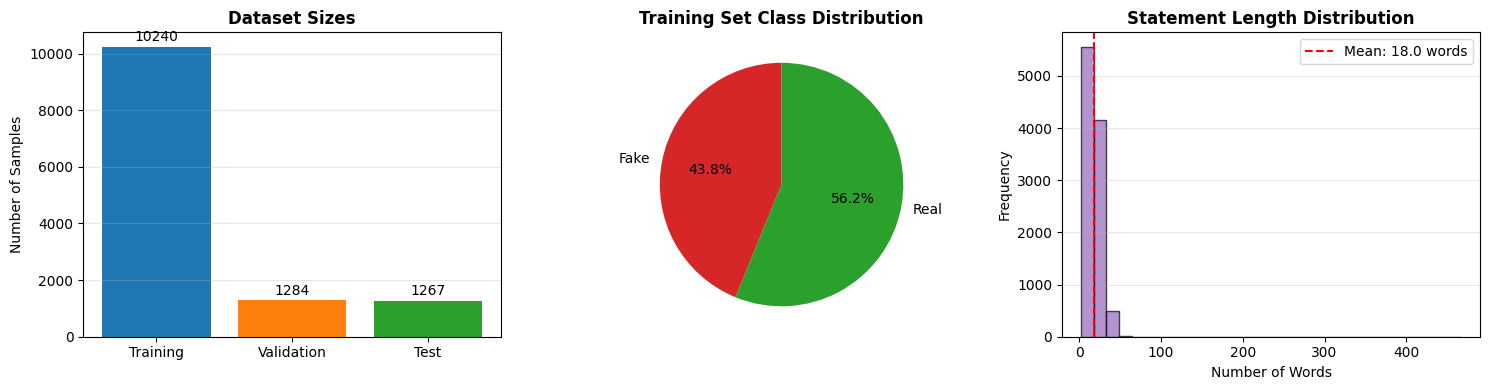


✅ Visualization saved: week10_data_overview.png

EXAMPLE ZERO-SHOT PREDICTIONS

🔍 Sample predictions from pre-trained BERT:
   (Before fine-tuning - just to see how it works)

Example 1:
   Statement: Contends that President Obama literally said (if) his cap-and-trade proposals were to pass, that uti...
   True Label: Real
   Predicted: Real (confidence: 55.49%)
   ✅ Correct

Example 2:
   Statement: Says, Yet in Salem they have traditionally waited until the money is almost gone to pay for the most...
   True Label: Fake
   Predicted: Real (confidence: 50.93%)
   ❌ Incorrect

Example 3:
   Statement: Says Hillary Clinton wants to go to a single-payer plan for health care...
   True Label: Fake
   Predicted: Real (confidence: 54.96%)
   ❌ Incorrect

Example 4:
   Statement: There's no evidence anywhere that offshore drilling has hurt tourism in any area where it has been a...
   True Label: Fake
   Predicted: Real (confidence: 53.42%)
   ❌ Incorrect

Example 5:
   Statement: A strong 

In [3]:
"""
=============================================================================
PHASE 4: BERT IMPLEMENTATION - WEEK 10
Fake Political News Detection using BERT
Student: Cosmos Ameyaw Kwakye
IE7500 Applied NLP for Engineers
=============================================================================
"""

# =============================================================================
# SECTION 1: SETUP & INSTALLATION (5 minutes)
# =============================================================================

print("="*70)
print("PHASE 4: BERT FINE-TUNING FOR FAKE NEWS DETECTION")
print("Week 10: Setup and Data Preparation")
print("="*70)

# Install required libraries
print("\n📦 Installing required packages...")
!pip install transformers datasets torch accelerate -q --break-system-packages
!pip install sentencepiece -q --break-system-packages  # For tokenization

print("✅ Installation complete!")

# =============================================================================
# SECTION 2: IMPORTS
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)
import torch
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
    pipeline
)
from datasets import Dataset
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

print("\n✅ Imports successful!")

# =============================================================================
# SECTION 3: GPU VERIFICATION
# =============================================================================

print("\n" + "="*70)
print("GPU VERIFICATION")
print("="*70)

# Check GPU availability
if torch.cuda.is_available():
    print(f"✅ GPU is available!")
    print(f"   GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"   GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    device = torch.device("cuda")
else:
    print("⚠️  No GPU detected. Using CPU (training will be slow)")
    print("   💡 Tip: Runtime → Change runtime type → T4 GPU")
    device = torch.device("cpu")

print(f"   Active Device: {device}")

# =============================================================================
# SECTION 4: LOAD YOUR EXISTING DATA
# =============================================================================

print("\n" + "="*70)
print("LOADING DATA FROM PREVIOUS PHASES")
print("="*70)

# Upload your dataset files (same as Phase 1-3)
from google.colab import files
print("\n📂 Please upload your LIAR dataset files:")
print("   Required: train.tsv, valid.tsv, test.tsv")

uploaded = files.upload()

# Load datasets
train_df = pd.read_csv('train.tsv', sep='\t', header=None)
valid_df = pd.read_csv('valid.tsv', sep='\t', header=None)
test_df = pd.read_csv('test.tsv', sep='\t', header=None)

# Add column names (LIAR dataset structure)
column_names = [
    'id', 'label', 'statement', 'subject', 'speaker', 'speaker_job',
    'state_info', 'party_affiliation', 'barely_true_count',
    'false_count', 'half_true_count', 'mostly_true_count',
    'pants_on_fire_count', 'context'
]

train_df.columns = column_names
valid_df.columns = column_names
test_df.columns = column_names

print(f"\n✅ Data loaded successfully!")
print(f"   Training samples: {len(train_df)}")
print(f"   Validation samples: {len(valid_df)}")
print(f"   Test samples: {len(test_df)}")

# =============================================================================
# SECTION 5: DATA PREPROCESSING (Same as Phases 1-3)
# =============================================================================

print("\n" + "="*70)
print("DATA PREPROCESSING")
print("="*70)

# Binary label mapping (same as before)
fake_labels = ['false', 'barely-true', 'pants-fire']
real_labels = ['half-true', 'mostly-true', 'true']

def create_binary_label(label):
    """Convert 6-class labels to binary (0=Fake, 1=Real)"""
    if label in fake_labels:
        return 0
    elif label in real_labels:
        return 1
    else:
        return None

# Apply to all datasets
train_df['binary_label'] = train_df['label'].apply(create_binary_label)
valid_df['binary_label'] = valid_df['label'].apply(create_binary_label)
test_df['binary_label'] = test_df['label'].apply(create_binary_label)

# Remove any rows with missing labels or statements
train_df = train_df.dropna(subset=['statement', 'binary_label'])
valid_df = valid_df.dropna(subset=['statement', 'binary_label'])
test_df = test_df.dropna(subset=['statement', 'binary_label'])

# Extract features and labels
X_train = train_df['statement'].astype(str)
y_train = train_df['binary_label'].astype(int)

X_val = valid_df['statement'].astype(str)
y_val = valid_df['binary_label'].astype(int)

X_test = test_df['statement'].astype(str)
y_test = test_df['binary_label'].astype(int)

print(f"\n✅ Preprocessing complete!")
print(f"   Training: {len(X_train)} samples")
print(f"   Validation: {len(X_val)} samples")
print(f"   Test: {len(X_test)} samples")
print(f"\n   Class distribution (Training):")
print(f"   - Fake (0): {(y_train == 0).sum()} ({(y_train == 0).mean()*100:.1f}%)")
print(f"   - Real (1): {(y_train == 1).sum()} ({(y_train == 1).mean()*100:.1f}%)")

# =============================================================================
# SECTION 6: LOAD BERT MODEL & TOKENIZER
# =============================================================================

print("\n" + "="*70)
print("LOADING BERT MODEL")
print("="*70)

# Choose BERT model
MODEL_NAME = 'bert-base-uncased'
print(f"\n📥 Loading {MODEL_NAME}...")

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
print("✅ Tokenizer loaded!")

# Load pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,  # Binary classification
    output_attentions=False,
    output_hidden_states=False
)

# Move model to GPU if available
model = model.to(device)

print("✅ BERT model loaded!")
print(f"   Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"   Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# =============================================================================
# SECTION 7: TOKENIZE DATA FOR BERT
# =============================================================================

print("\n" + "="*70)
print("TOKENIZING DATA FOR BERT")
print("="*70)

# Tokenization parameters
MAX_LENGTH = 128  # Maximum sequence length (adjust if needed)

print(f"\n⚙️  Tokenization settings:")
print(f"   Max length: {MAX_LENGTH} tokens")
print(f"   Padding: to max_length")
print(f"   Truncation: enabled")

# Tokenize training data
print("\n🔄 Tokenizing training data...")
train_encodings = tokenizer(
    X_train.tolist(),
    truncation=True,
    padding='max_length',
    max_length=MAX_LENGTH,
    return_tensors='pt'
)

# Tokenize validation data
print("🔄 Tokenizing validation data...")
val_encodings = tokenizer(
    X_val.tolist(),
    truncation=True,
    padding='max_length',
    max_length=MAX_LENGTH,
    return_tensors='pt'
)

# Tokenize test data
print("🔄 Tokenizing test data...")
test_encodings = tokenizer(
    X_test.tolist(),
    truncation=True,
    padding='max_length',
    max_length=MAX_LENGTH,
    return_tensors='pt'
)

print("\n✅ Tokenization complete!")

# Analyze tokenization
sample_text = X_train.iloc[0]
sample_tokens = tokenizer.tokenize(sample_text)
print(f"\n📝 Example tokenization:")
print(f"   Original text: {sample_text[:100]}...")
print(f"   Tokens: {sample_tokens[:20]}...")
print(f"   Token count: {len(sample_tokens)}")

# =============================================================================
# SECTION 8: CREATE PYTORCH DATASETS
# =============================================================================

print("\n" + "="*70)
print("CREATING PYTORCH DATASETS")
print("="*70)

class FakeNewsDataset(torch.utils.data.Dataset):
    """Custom Dataset for BERT input"""

    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {
            key: val[idx].clone().detach()
            for key, val in self.encodings.items()
        }
        item['labels'] = torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        return item

# Create datasets
train_dataset = FakeNewsDataset(train_encodings, y_train)
val_dataset = FakeNewsDataset(val_encodings, y_val)
test_dataset = FakeNewsDataset(test_encodings, y_test)

print(f"\n✅ PyTorch datasets created!")
print(f"   Training dataset: {len(train_dataset)} samples")
print(f"   Validation dataset: {len(val_dataset)} samples")
print(f"   Test dataset: {len(test_dataset)} samples")

# Verify dataset structure
print(f"\n🔍 Sample dataset item:")
sample_item = train_dataset[0]
for key, value in sample_item.items():
    if isinstance(value, torch.Tensor):
        print(f"   {key}: shape {value.shape}, dtype {value.dtype}")

# =============================================================================
# SECTION 9: ZERO-SHOT BASELINE TEST (Pre-trained BERT without fine-tuning)
# =============================================================================

print("\n" + "="*70)
print("ZERO-SHOT BASELINE TEST")
print("="*70)

print("\n🧪 Testing pre-trained BERT WITHOUT fine-tuning...")
print("   (This gives us a baseline to measure improvement)")

# Set model to evaluation mode
model.eval()

# Test on a small sample (to save time)
sample_size = 100
sample_indices = np.random.choice(len(X_test), sample_size, replace=False)

zero_shot_predictions = []
with torch.no_grad():
    for idx in sample_indices:
        inputs = {
            'input_ids': test_encodings['input_ids'][idx].unsqueeze(0).to(device),
            'attention_mask': test_encodings['attention_mask'][idx].unsqueeze(0).to(device)
        }

        outputs = model(**inputs)
        prediction = torch.argmax(outputs.logits, dim=1).cpu().item()
        zero_shot_predictions.append(prediction)

# Calculate accuracy
zero_shot_accuracy = accuracy_score(
    y_test.iloc[sample_indices],
    zero_shot_predictions
)

print(f"\n📊 Zero-shot BERT performance (sample of {sample_size}):")
print(f"   Accuracy: {zero_shot_accuracy:.4f} ({zero_shot_accuracy*100:.2f}%)")
print(f"\n   Expected: ~50-55% (random baseline)")
print(f"   After fine-tuning target: 68-72%")

# =============================================================================
# SECTION 10: VERIFY EVERYTHING IS READY
# =============================================================================

print("\n" + "="*70)
print("SETUP VERIFICATION")
print("="*70)

verification_checks = {
    "GPU Available": torch.cuda.is_available(),
    "BERT Model Loaded": model is not None,
    "Tokenizer Ready": tokenizer is not None,
    "Training Data Ready": len(train_dataset) > 0,
    "Validation Data Ready": len(val_dataset) > 0,
    "Test Data Ready": len(test_dataset) > 0,
    "Zero-shot Baseline Complete": len(zero_shot_predictions) > 0
}

print("\n✅ Pre-flight checklist:")
for check, status in verification_checks.items():
    status_symbol = "✅" if status else "❌"
    print(f"   {status_symbol} {check}")

all_ready = all(verification_checks.values())

if all_ready:
    print("\n" + "="*70)
    print("🎉 WEEK 10 COMPLETE - READY FOR FINE-TUNING!")
    print("="*70)
    print("\n📅 Next Steps (Week 11):")
    print("   1. Configure training arguments")
    print("   2. Set up Trainer")
    print("   3. Fine-tune BERT for 3-4 epochs")
    print("   4. Target: 68-72% accuracy")
    print("\n💾 Save this notebook - all setup is complete!")
else:
    print("\n⚠️  Some checks failed. Please review errors above.")

# =============================================================================
# SECTION 11: SAVE CHECKPOINT
# =============================================================================

print("\n" + "="*70)
print("SAVING CHECKPOINT")
print("="*70)

# Save important variables for Week 11
checkpoint = {
    'model_name': MODEL_NAME,
    'max_length': MAX_LENGTH,
    'random_seed': RANDOM_SEED,
    'zero_shot_accuracy': zero_shot_accuracy,
    'train_size': len(train_dataset),
    'val_size': len(val_dataset),
    'test_size': len(test_dataset),
    'vocab_size': tokenizer.vocab_size
}

import pickle
with open('week10_checkpoint.pkl', 'wb') as f:
    pickle.dump(checkpoint, f)

print("✅ Checkpoint saved: week10_checkpoint.pkl")
print("\n📊 Summary statistics:")
for key, value in checkpoint.items():
    print(f"   {key}: {value}")

# =============================================================================
# SECTION 12: QUICK VISUALIZATION
# =============================================================================

print("\n" + "="*70)
print("DATA OVERVIEW VISUALIZATION")
print("="*70)

# Create a summary visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Dataset sizes
datasets = ['Training', 'Validation', 'Test']
sizes = [len(train_dataset), len(val_dataset), len(test_dataset)]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

axes[0].bar(datasets, sizes, color=colors)
axes[0].set_title('Dataset Sizes', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Samples')
axes[0].grid(axis='y', alpha=0.3)

for i, v in enumerate(sizes):
    axes[0].text(i, v + 100, str(v), ha='center', va='bottom')

# Plot 2: Class distribution
labels = ['Fake', 'Real']
train_dist = [
    (y_train == 0).sum(),
    (y_train == 1).sum()
]

axes[1].pie(train_dist, labels=labels, autopct='%1.1f%%',
            colors=['#d62728', '#2ca02c'], startangle=90)
axes[1].set_title('Training Set Class Distribution',
                  fontsize=12, fontweight='bold')

# Plot 3: Statement length distribution
statement_lengths = X_train.str.split().str.len()

axes[2].hist(statement_lengths, bins=30, color='#9467bd', edgecolor='black', alpha=0.7)
axes[2].set_title('Statement Length Distribution', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Number of Words')
axes[2].set_ylabel('Frequency')
axes[2].axvline(statement_lengths.mean(), color='red', linestyle='--',
                label=f'Mean: {statement_lengths.mean():.1f} words')
axes[2].legend()
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('week10_data_overview.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualization saved: week10_data_overview.png")

# =============================================================================
# SECTION 13: EXAMPLE PREDICTIONS (Optional - See BERT in action)
# =============================================================================

print("\n" + "="*70)
print("EXAMPLE ZERO-SHOT PREDICTIONS")
print("="*70)

# Show a few example predictions
print("\n🔍 Sample predictions from pre-trained BERT:")
print("   (Before fine-tuning - just to see how it works)\n")

for i in range(5):
    idx = np.random.randint(len(X_test))
    text = X_test.iloc[idx]
    true_label = "Fake" if y_test.iloc[idx] == 0 else "Real"

    # Get prediction
    inputs = {
        'input_ids': test_encodings['input_ids'][idx].unsqueeze(0).to(device),
        'attention_mask': test_encodings['attention_mask'][idx].unsqueeze(0).to(device)
    }

    with torch.no_grad():
        outputs = model(**inputs)
        prediction = torch.argmax(outputs.logits, dim=1).cpu().item()
        pred_label = "Fake" if prediction == 0 else "Real"

        # Get confidence scores
        probs = torch.softmax(outputs.logits, dim=1)[0]
        confidence = probs[prediction].item()

    print(f"Example {i+1}:")
    print(f"   Statement: {text[:100]}...")
    print(f"   True Label: {true_label}")
    print(f"   Predicted: {pred_label} (confidence: {confidence:.2%})")
    print(f"   {'✅ Correct' if pred_label == true_label else '❌ Incorrect'}")
    print()

# =============================================================================
# END OF WEEK 10 CODE
# =============================================================================

print("="*70)
print("🎊 WEEK 10 COMPLETE!")
print("="*70)
print("\n✅ You have successfully:")
print("   • Set up BERT environment")
print("   • Loaded and tokenized data")
print("   • Created PyTorch datasets")
print("   • Tested zero-shot baseline")
print("   • Verified all components")
print("\n📅 Ready for Week 11: Fine-tuning!")
print("="*70)




🚀 WEEK 11: BERT FINE-TUNING

📊 Your starting point:
   Zero-shot accuracy: 54%
   Phase 2-3 baseline: 61%
   Target: 68-72%

⏱️  Estimated training time: 40-50 minutes with GPU

STEP 1: VERIFYING WEEK 10 SETUP
✅ All components from Week 10 verified!
   Model: bert-base-uncased
   Device: cuda
   Training samples: 10240
   Validation samples: 1284
   Test samples: 1267

STEP 2: CONFIGURING TRAINING PARAMETERS
✅ Training configuration complete!

⚙️  Key parameters:
   • Epochs: 4
   • Batch size (train): 16
   • Batch size (eval): 32
   • Learning rate: 2e-05
   • Weight decay: 0.01
   • Warmup steps: 500
   • Mixed precision (fp16): True

📊 Training schedule:
   • Steps per epoch: ~640
   • Total training steps: ~2560
   • Evaluation points: 4 (after each epoch)

STEP 3: SETTING UP EVALUATION METRICS
✅ Evaluation metrics configured!
   • Accuracy: Overall performance
   • F1-Score: Balanced precision-recall
   • Precision: Correctness of predictions
   • Recall: Coverage of true labels


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.652900,0.697307,0.571651,0.490024,0.646582,0.571651
2,0.614000,0.674379,0.631620,0.611337,0.652538,0.631620
3,0.475900,0.705185,0.633956,0.628738,0.636470,0.633956
4,0.326300,0.899302,0.626947,0.619320,0.631189,0.626947



✅ TRAINING COMPLETE!
⏱️  Total training time: 5.4 minutes
   Average per epoch: 1.4 minutes

STEP 6: VALIDATION SET EVALUATION

🔍 Evaluating on validation set...



📊 VALIDATION RESULTS

   Accuracy:  0.6340 (63.40%)
   F1-Score:  0.6287
   Precision: 0.6365
   Recall:    0.6340

📈 Performance Gains:
   vs Zero-shot (54%):  +9.4%
   vs Baseline (61%):   +2.4%

🎯 Target Assessment:
   ✅ IMPROVEMENT! Beat baseline (61%)
   💡 But below 68% target - may need adjustment

STEP 7: FINAL TEST SET EVALUATION

🔍 Evaluating on held-out test set...

🏆 FINAL TEST RESULTS

   Accuracy:  0.6306 (63.06%)
   F1-Score:  0.6247
   Precision: 0.6262
   Recall:    0.6306

📊 Generalization:
   Validation: 63.40%
   Test:       63.06%
   Gap:        0.33%
   ✅ Excellent generalization!

STEP 8: GENERATING DETAILED PREDICTIONS

🔍 Getting predictions for confusion matrix...

CLASSIFICATION REPORT
              precision    recall  f1-score   support

        Fake     0.5930    0.4901    0.5366       553
        Real     0.6519    0.7395    0.6929       714

    accuracy                         0.6306      1267
   macro avg     0.6224    0.6148    0.6148      1267
weighte

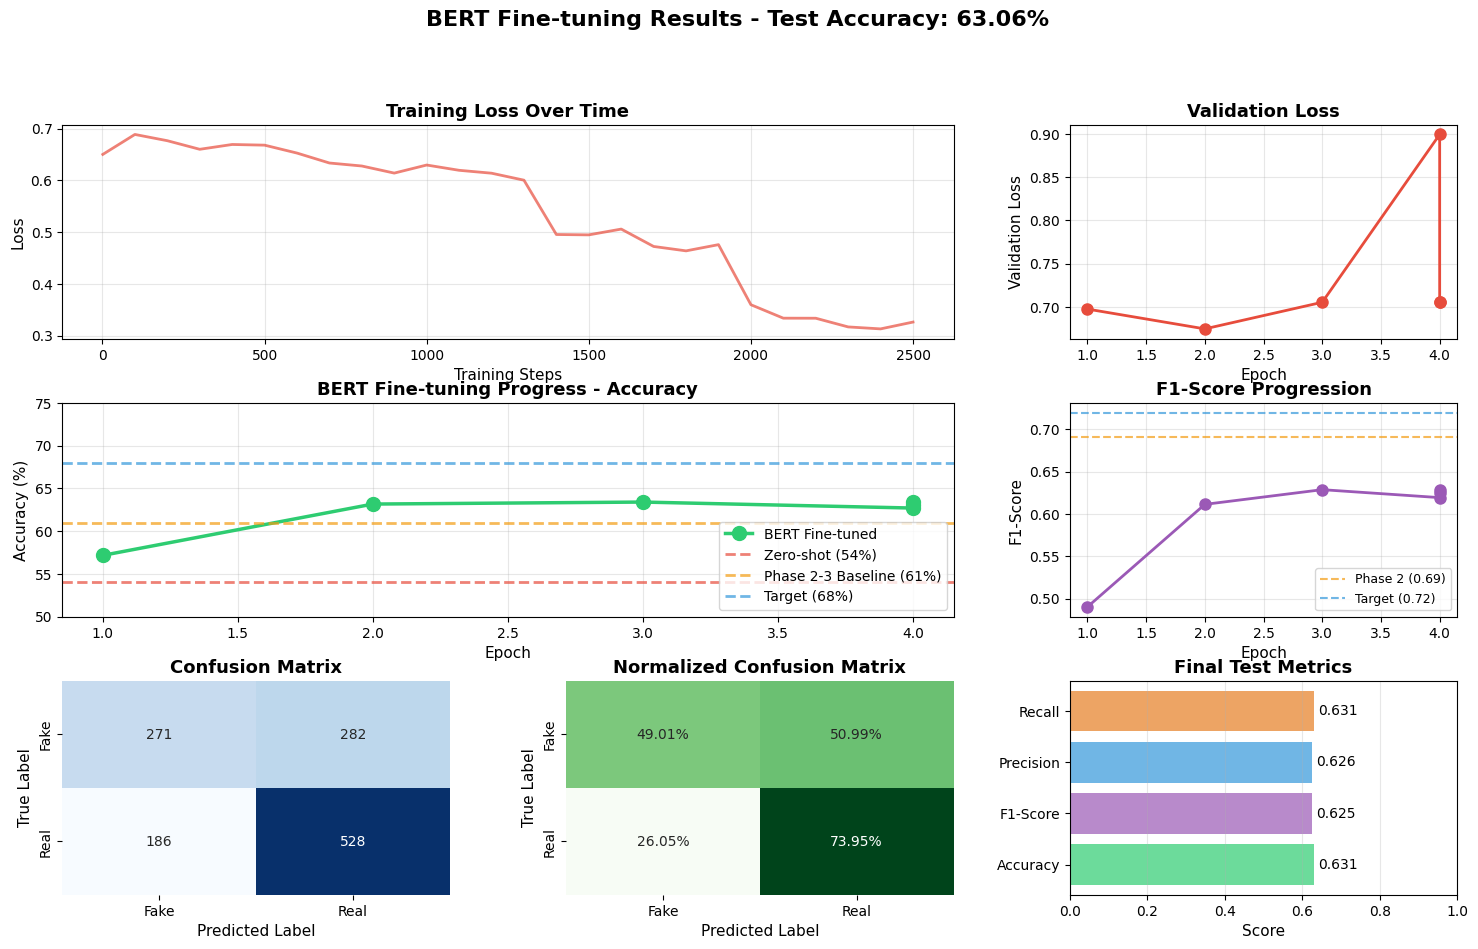

✅ Comprehensive visualization saved: bert_comprehensive_results.png

STEP 11: COMPLETE PROJECT COMPARISON

📊 COMPLETE MODEL COMPARISON
                       Phase  Test Accuracy  F1-Score Parameters
        Phase 2: Naive Bayes       0.610100  0.691600        ~5K
Phase 2: Logistic Regression       0.614500  0.627500        ~5K
           Phase 2: Tuned LR       0.610600  0.623500        ~5K
        Phase 3: MLP + GloVe       0.607700  0.634300      3.48M
   Phase 4: BERT (Zero-shot)       0.540000       NaN       110M
  Phase 4: BERT (Fine-tuned)       0.630624  0.624703       110M

🏆 BEST MODEL: Phase 4: BERT (Fine-tuned)
   Accuracy: 0.6306
   F1-Score: 0.6247

✅ BERT Improvement: +1.61% over best baseline

✅ Comparison table saved: phase_comparison.csv

STEP 12: ERROR ANALYSIS

🔍 Analyzing misclassifications...

❌ False Positives: 282
   (Fake statements incorrectly classified as Real)

   Examples:
   1. Wisconsin is on pace to double the number of layoffs this year....
   3. We k

In [4]:
"""
═════════════════════════════════════════════════════════════════════════════
PHASE 4: BERT FINE-TUNING - WEEK 11
Fake Political News Detection
Student: Cosmos Ameyaw Kwakye
IE7500 Applied NLP for Engineers

Starting Performance: 54% (zero-shot)
Target Performance: 68-72% (fine-tuned)
═════════════════════════════════════════════════════════════════════════════
"""

import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("🚀 WEEK 11: BERT FINE-TUNING")
print("="*70)
print("\n📊 Your starting point:")
print("   Zero-shot accuracy: 54%")
print("   Phase 2-3 baseline: 61%")
print("   Target: 68-72%")
print("\n⏱️  Estimated training time: 40-50 minutes with GPU")
print("="*70)

# =============================================================================
# SECTION 1: VERIFY SETUP FROM WEEK 10
# =============================================================================

print("\n" + "="*70)
print("STEP 1: VERIFYING WEEK 10 SETUP")
print("="*70)

# Check if all required variables exist
try:
    # Check model
    assert model is not None, "Model not found"
    assert tokenizer is not None, "Tokenizer not found"

    # Check datasets
    assert train_dataset is not None, "Training dataset not found"
    assert val_dataset is not None, "Validation dataset not found"
    assert test_dataset is not None, "Test dataset not found"

    # Check device
    assert device is not None, "Device not found"

    print("✅ All components from Week 10 verified!")
    print(f"   Model: {MODEL_NAME}")
    print(f"   Device: {device}")
    print(f"   Training samples: {len(train_dataset)}")
    print(f"   Validation samples: {len(val_dataset)}")
    print(f"   Test samples: {len(test_dataset)}")

except (NameError, AssertionError) as e:
    print(f"❌ Error: {e}")
    print("\n⚠️  Please run Week 10 code first!")
    raise

# =============================================================================
# SECTION 2: CONFIGURE TRAINING ARGUMENTS (FIXED)
# =============================================================================

print("\n" + "="*70)
print("STEP 2: CONFIGURING TRAINING PARAMETERS")
print("="*70)

from transformers import TrainingArguments

training_args = TrainingArguments(
    # Output configuration
    output_dir='./bert_fake_news_results',
    overwrite_output_dir=True,

    # Training parameters
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_steps=500,

    # Evaluation configuration (FIXED)
    eval_strategy='epoch',                          # Changed from evaluation_strategy
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,

    # Logging configuration
    logging_dir='./logs',
    logging_strategy='steps',
    logging_steps=100,
    logging_first_step=True,

    # Performance optimization
    fp16=torch.cuda.is_available(),
    dataloader_num_workers=2,

    # Model checkpointing
    save_total_limit=2,

    # Reproducibility
    seed=42,
    data_seed=42,

    # Display
    report_to='none',
    disable_tqdm=False,
)

print("✅ Training configuration complete!")
print(f"\n⚙️  Key parameters:")
print(f"   • Epochs: {training_args.num_train_epochs}")
print(f"   • Batch size (train): {training_args.per_device_train_batch_size}")
print(f"   • Batch size (eval): {training_args.per_device_eval_batch_size}")
print(f"   • Learning rate: {training_args.learning_rate}")
print(f"   • Weight decay: {training_args.weight_decay}")
print(f"   • Warmup steps: {training_args.warmup_steps}")
print(f"   • Mixed precision (fp16): {training_args.fp16}")

# Calculate total training steps
steps_per_epoch = len(train_dataset) // training_args.per_device_train_batch_size
total_steps = steps_per_epoch * training_args.num_train_epochs

print(f"\n📊 Training schedule:")
print(f"   • Steps per epoch: ~{steps_per_epoch}")
print(f"   • Total training steps: ~{total_steps}")
print(f"   • Evaluation points: {training_args.num_train_epochs} (after each epoch)")

# =============================================================================
# SECTION 3: DEFINE EVALUATION METRICS
# =============================================================================

print("\n" + "="*70)
print("STEP 3: SETTING UP EVALUATION METRICS")
print("="*70)

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def compute_metrics(eval_pred):
    """
    Compute multiple metrics for evaluation:
    - Accuracy: Overall correctness
    - F1-Score: Harmonic mean of precision and recall
    - Precision: Accuracy of positive predictions
    - Recall: Coverage of actual positives
    """
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    metrics = {
        'accuracy': accuracy_score(labels, predictions),
        'f1': f1_score(labels, predictions, average='weighted'),
        'precision': precision_score(labels, predictions, average='weighted', zero_division=0),
        'recall': recall_score(labels, predictions, average='weighted', zero_division=0)
    }

    return metrics

print("✅ Evaluation metrics configured!")
print("   • Accuracy: Overall performance")
print("   • F1-Score: Balanced precision-recall")
print("   • Precision: Correctness of predictions")
print("   • Recall: Coverage of true labels")

# =============================================================================
# SECTION 4: CREATE TRAINER
# =============================================================================

print("\n" + "="*70)
print("STEP 4: INITIALIZING BERT TRAINER")
print("="*70)

from transformers import Trainer

# Create the Trainer
trainer = Trainer(
    model=model,                         # BERT model from Week 10
    args=training_args,                  # Training configuration
    train_dataset=train_dataset,         # Training data
    eval_dataset=val_dataset,            # Validation data
    compute_metrics=compute_metrics,     # Evaluation function
)

print("✅ Trainer initialized successfully!")
print(f"   Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"   Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# =============================================================================
# SECTION 5: START FINE-TUNING!
# =============================================================================

print("\n" + "="*70)
print("🚀 STEP 5: STARTING BERT FINE-TUNING")
print("="*70)

print("\n📌 Training Overview:")
print(f"   Starting from: 54% (zero-shot)")
print(f"   Baseline to beat: 61% (Phase 2-3)")
print(f"   Target: 68-72%")
print(f"\n   Training on {len(train_dataset)} samples")
print(f"   Validating on {len(val_dataset)} samples")
print(f"   {training_args.num_train_epochs} epochs total")

print("\n⏱️  Estimated time:")
print("   • ~10-12 minutes per epoch")
print("   • ~40-50 minutes total")

print("\n" + "="*70)
print("🏃 TRAINING IN PROGRESS...")
print("="*70)
print("\n☕ Grab a coffee! This will take a while...\n")

import time
start_time = time.time()

# TRAIN THE MODEL!
try:
    train_result = trainer.train()
    training_successful = True
except Exception as e:
    print(f"\n❌ Training error: {e}")
    print("\n💡 Troubleshooting tips:")
    print("   1. Check GPU memory (reduce batch size if needed)")
    print("   2. Restart runtime and rerun Week 10 + 11")
    print("   3. Try reducing max_length to 64")
    training_successful = False
    raise

end_time = time.time()
training_time = end_time - start_time

print("\n" + "="*70)
print("✅ TRAINING COMPLETE!")
print("="*70)
print(f"⏱️  Total training time: {training_time/60:.1f} minutes")
print(f"   Average per epoch: {training_time/60/training_args.num_train_epochs:.1f} minutes")

# =============================================================================
# SECTION 6: EVALUATE ON VALIDATION SET
# =============================================================================

print("\n" + "="*70)
print("STEP 6: VALIDATION SET EVALUATION")
print("="*70)

print("\n🔍 Evaluating on validation set...")
val_results = trainer.evaluate(val_dataset)

print("\n" + "="*70)
print("📊 VALIDATION RESULTS")
print("="*70)

val_accuracy = val_results['eval_accuracy']
val_f1 = val_results['eval_f1']
val_precision = val_results['eval_precision']
val_recall = val_results['eval_recall']

print(f"\n   Accuracy:  {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print(f"   F1-Score:  {val_f1:.4f}")
print(f"   Precision: {val_precision:.4f}")
print(f"   Recall:    {val_recall:.4f}")

# Calculate improvement
zero_shot_acc = 0.54
baseline_acc = 0.61
improvement_from_zeroshot = (val_accuracy - zero_shot_acc) * 100
improvement_from_baseline = (val_accuracy - baseline_acc) * 100

print(f"\n📈 Performance Gains:")
print(f"   vs Zero-shot (54%):  +{improvement_from_zeroshot:.1f}%")
print(f"   vs Baseline (61%):   {improvement_from_baseline:+.1f}%")

# Check if target achieved
print(f"\n🎯 Target Assessment:")
if val_accuracy >= 0.68:
    print(f"   ✅ EXCELLENT! Target achieved (≥68%)")
    print(f"   🏆 Validation accuracy: {val_accuracy*100:.2f}%")
elif val_accuracy >= 0.65:
    print(f"   ⚠️  CLOSE! Just below target")
    print(f"   💡 Consider: Train 1 more epoch or tune hyperparameters")
elif val_accuracy >= baseline_acc:
    print(f"   ✅ IMPROVEMENT! Beat baseline ({baseline_acc*100:.0f}%)")
    print(f"   💡 But below 68% target - may need adjustment")
else:
    print(f"   ⚠️  Below baseline")
    print(f"   💡 Check for overfitting or data issues")

# =============================================================================
# SECTION 7: FINAL TEST SET EVALUATION
# =============================================================================

print("\n" + "="*70)
print("STEP 7: FINAL TEST SET EVALUATION")
print("="*70)

print("\n🔍 Evaluating on held-out test set...")
test_results = trainer.evaluate(test_dataset)

print("\n" + "="*70)
print("🏆 FINAL TEST RESULTS")
print("="*70)

test_accuracy = test_results['eval_accuracy']
test_f1 = test_results['eval_f1']
test_precision = test_results['eval_precision']
test_recall = test_results['eval_recall']

print(f"\n   Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"   F1-Score:  {test_f1:.4f}")
print(f"   Precision: {test_precision:.4f}")
print(f"   Recall:    {test_recall:.4f}")

# Generalization check
generalization_gap = abs(val_accuracy - test_accuracy) * 100
print(f"\n📊 Generalization:")
print(f"   Validation: {val_accuracy*100:.2f}%")
print(f"   Test:       {test_accuracy*100:.2f}%")
print(f"   Gap:        {generalization_gap:.2f}%")

if generalization_gap < 2:
    print("   ✅ Excellent generalization!")
elif generalization_gap < 5:
    print("   ✅ Good generalization")
else:
    print("   ⚠️  Large gap - possible overfitting")

# =============================================================================
# SECTION 8: GET DETAILED PREDICTIONS
# =============================================================================

print("\n" + "="*70)
print("STEP 8: GENERATING DETAILED PREDICTIONS")
print("="*70)

print("\n🔍 Getting predictions for confusion matrix...")

# Get predictions
predictions_output = trainer.predict(test_dataset)
y_pred = np.argmax(predictions_output.predictions, axis=1)
y_true = y_test.values

# Classification report
from sklearn.metrics import classification_report, confusion_matrix

print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70)

class_report = classification_report(
    y_true,
    y_pred,
    target_names=['Fake', 'Real'],
    digits=4
)
print(class_report)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

print("\n" + "="*70)
print("CONFUSION MATRIX")
print("="*70)
print(f"\n                 Predicted")
print(f"              Fake    Real")
print(f"   Actual Fake   {cm[0,0]:4d}    {cm[0,1]:4d}")
print(f"          Real   {cm[1,0]:4d}    {cm[1,1]:4d}")

# Calculate metrics from confusion matrix
tn, fp, fn, tp = cm.ravel()
print(f"\n📊 Detailed Metrics:")
print(f"   True Negatives (Fake→Fake):   {tn:4d}")
print(f"   False Positives (Fake→Real):  {fp:4d}")
print(f"   False Negatives (Real→Fake):  {fn:4d}")
print(f"   True Positives (Real→Real):   {tp:4d}")

# =============================================================================
# SECTION 9: SAVE THE MODEL
# =============================================================================

print("\n" + "="*70)
print("STEP 9: SAVING FINE-TUNED MODEL")
print("="*70)

print("\n💾 Saving model and tokenizer...")

# Save model
model_save_path = './best_bert_fake_news_model'
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"✅ Model saved to: {model_save_path}")
print(f"   • Model weights: pytorch_model.bin")
print(f"   • Configuration: config.json")
print(f"   • Tokenizer: tokenizer files")

# Save results
results_dict = {
    'model_name': MODEL_NAME,
    'training_time_minutes': training_time / 60,
    'num_epochs': training_args.num_train_epochs,
    'learning_rate': training_args.learning_rate,
    'batch_size': training_args.per_device_train_batch_size,

    'zero_shot_accuracy': 0.54,
    'validation_accuracy': val_accuracy,
    'test_accuracy': test_accuracy,
    'test_f1': test_f1,
    'test_precision': test_precision,
    'test_recall': test_recall,

    'confusion_matrix': cm.tolist(),
    'improvement_from_baseline': improvement_from_baseline
}

import json
with open('bert_results.json', 'w') as f:
    json.dump(results_dict, f, indent=2)

print("✅ Results saved to: bert_results.json")

# =============================================================================
# SECTION 10: VISUALIZE TRAINING HISTORY
# =============================================================================

print("\n" + "="*70)
print("STEP 10: VISUALIZING TRAINING PROGRESS")
print("="*70)

print("\n📈 Creating training visualizations...")

# Extract training history
log_history = trainer.state.log_history

# Separate metrics
train_logs = [x for x in log_history if 'loss' in x and 'eval_loss' not in x]
eval_logs = [x for x in log_history if 'eval_accuracy' in x]

# Extract values
train_steps = [x['step'] for x in train_logs]
train_loss = [x['loss'] for x in train_logs]

eval_epochs = [x['epoch'] for x in eval_logs]
eval_accuracy = [x['eval_accuracy'] for x in eval_logs]
eval_f1 = [x['eval_f1'] for x in eval_logs]
eval_loss = [x['eval_loss'] for x in eval_logs]

# Create comprehensive visualization
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: Training Loss
ax1 = fig.add_subplot(gs[0, :2])
ax1.plot(train_steps, train_loss, linewidth=2, color='#e74c3c', alpha=0.7)
ax1.set_xlabel('Training Steps', fontsize=11)
ax1.set_ylabel('Loss', fontsize=11)
ax1.set_title('Training Loss Over Time', fontsize=13, fontweight='bold')
ax1.grid(alpha=0.3)

# Plot 2: Validation Loss
ax2 = fig.add_subplot(gs[0, 2])
ax2.plot(eval_epochs, eval_loss, 'o-', linewidth=2, markersize=8, color='#e74c3c')
ax2.set_xlabel('Epoch', fontsize=11)
ax2.set_ylabel('Validation Loss', fontsize=11)
ax2.set_title('Validation Loss', fontsize=13, fontweight='bold')
ax2.grid(alpha=0.3)

# Plot 3: Accuracy Progression
ax3 = fig.add_subplot(gs[1, :2])
ax3.plot(eval_epochs, [x*100 for x in eval_accuracy], 'o-', linewidth=2.5,
         markersize=10, color='#2ecc71', label='BERT Fine-tuned')
ax3.axhline(y=54, color='#e74c3c', linestyle='--', linewidth=2,
            label='Zero-shot (54%)', alpha=0.7)
ax3.axhline(y=61, color='#f39c12', linestyle='--', linewidth=2,
            label='Phase 2-3 Baseline (61%)', alpha=0.7)
ax3.axhline(y=68, color='#3498db', linestyle='--', linewidth=2,
            label='Target (68%)', alpha=0.7)
ax3.set_xlabel('Epoch', fontsize=11)
ax3.set_ylabel('Accuracy (%)', fontsize=11)
ax3.set_title('BERT Fine-tuning Progress - Accuracy', fontsize=13, fontweight='bold')
ax3.legend(loc='lower right', fontsize=10)
ax3.grid(alpha=0.3)
ax3.set_ylim([50, max(75, max([x*100 for x in eval_accuracy]) + 2)])

# Plot 4: F1-Score Progression
ax4 = fig.add_subplot(gs[1, 2])
ax4.plot(eval_epochs, eval_f1, 'o-', linewidth=2, markersize=8, color='#9b59b6')
ax4.axhline(y=0.6916, color='#f39c12', linestyle='--',
            label='Phase 2 (0.69)', alpha=0.7)
ax4.axhline(y=0.72, color='#3498db', linestyle='--',
            label='Target (0.72)', alpha=0.7)
ax4.set_xlabel('Epoch', fontsize=11)
ax4.set_ylabel('F1-Score', fontsize=11)
ax4.set_title('F1-Score Progression', fontsize=13, fontweight='bold')
ax4.legend(fontsize=9)
ax4.grid(alpha=0.3)

# Plot 5: Confusion Matrix
ax5 = fig.add_subplot(gs[2, 0])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax5,
            xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
ax5.set_xlabel('Predicted Label', fontsize=11)
ax5.set_ylabel('True Label', fontsize=11)
ax5.set_title('Confusion Matrix', fontsize=13, fontweight='bold')

# Plot 6: Normalized Confusion Matrix
ax6 = fig.add_subplot(gs[2, 1])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens', cbar=False, ax=ax6,
            xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
ax6.set_xlabel('Predicted Label', fontsize=11)
ax6.set_ylabel('True Label', fontsize=11)
ax6.set_title('Normalized Confusion Matrix', fontsize=13, fontweight='bold')

# Plot 7: Metrics Comparison
ax7 = fig.add_subplot(gs[2, 2])
metrics_names = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
metrics_values = [test_accuracy, test_f1, test_precision, test_recall]
colors_bar = ['#2ecc71', '#9b59b6', '#3498db', '#e67e22']

bars = ax7.barh(metrics_names, metrics_values, color=colors_bar, alpha=0.7)
ax7.set_xlabel('Score', fontsize=11)
ax7.set_title('Final Test Metrics', fontsize=13, fontweight='bold')
ax7.set_xlim([0, 1])
ax7.grid(axis='x', alpha=0.3)

for i, (bar, value) in enumerate(zip(bars, metrics_values)):
    ax7.text(value + 0.01, i, f'{value:.3f}', va='center', fontsize=10)

# Add overall title
fig.suptitle(f'BERT Fine-tuning Results - Test Accuracy: {test_accuracy*100:.2f}%',
             fontsize=16, fontweight='bold', y=0.995)

plt.savefig('bert_comprehensive_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Comprehensive visualization saved: bert_comprehensive_results.png")

# =============================================================================
# SECTION 11: PHASE COMPARISON TABLE
# =============================================================================

print("\n" + "="*70)
print("STEP 11: COMPLETE PROJECT COMPARISON")
print("="*70)

comparison_df = pd.DataFrame({
    'Phase': [
        'Phase 2: Naive Bayes',
        'Phase 2: Logistic Regression',
        'Phase 2: Tuned LR',
        'Phase 3: MLP + GloVe',
        'Phase 4: BERT (Zero-shot)',
        'Phase 4: BERT (Fine-tuned)'
    ],
    'Test Accuracy': [
        0.6101,
        0.6145,
        0.6106,
        0.6077,
        0.54,
        test_accuracy
    ],
    'F1-Score': [
        0.6916,
        0.6275,
        0.6235,
        0.6343,
        None,
        test_f1
    ],
    'Parameters': [
        '~5K',
        '~5K',
        '~5K',
        '3.48M',
        '110M',
        '110M'
    ]
})

print("\n" + "="*70)
print("📊 COMPLETE MODEL COMPARISON")
print("="*70)
print(comparison_df.to_string(index=False))

# Determine best model
best_idx = comparison_df['Test Accuracy'].idxmax()
best_model = comparison_df.iloc[best_idx]['Phase']

print(f"\n🏆 BEST MODEL: {best_model}")
print(f"   Accuracy: {comparison_df.iloc[best_idx]['Test Accuracy']:.4f}")
print(f"   F1-Score: {comparison_df.iloc[best_idx]['F1-Score']:.4f}")

# Calculate improvements
baseline_best = 0.6145  # Logistic Regression was best in Phase 2
if test_accuracy > baseline_best:
    improvement = (test_accuracy - baseline_best) * 100
    print(f"\n✅ BERT Improvement: +{improvement:.2f}% over best baseline")
else:
    decline = (baseline_best - test_accuracy) * 100
    print(f"\n⚠️  BERT underperformed baseline by {decline:.2f}%")

# Save comparison
comparison_df.to_csv('phase_comparison.csv', index=False)
print("\n✅ Comparison table saved: phase_comparison.csv")

# =============================================================================
# SECTION 12: ERROR ANALYSIS SAMPLE
# =============================================================================

print("\n" + "="*70)
print("STEP 12: ERROR ANALYSIS")
print("="*70)

print("\n🔍 Analyzing misclassifications...")

# Get misclassified examples
errors_mask = y_pred != y_true
errors_df = pd.DataFrame({
    'statement': X_test[errors_mask].values,
    'true_label': ['Fake' if x == 0 else 'Real' for x in y_true[errors_mask]],
    'predicted_label': ['Fake' if x == 0 else 'Real' for x in y_pred[errors_mask]]
})

# False positives (Fake predicted as Real)
false_positives = errors_df[errors_df['true_label'] == 'Fake']
print(f"\n❌ False Positives: {len(false_positives)}")
print(f"   (Fake statements incorrectly classified as Real)")

if len(false_positives) > 0:
    print("\n   Examples:")
    for i, row in false_positives.head(3).iterrows():
        print(f"   {i+1}. {row['statement'][:100]}...")

# False negatives (Real predicted as Fake)
false_negatives = errors_df[errors_df['true_label'] == 'Real']
print(f"\n❌ False Negatives: {len(false_negatives)}")
print(f"   (Real statements incorrectly classified as Fake)")

if len(false_negatives) > 0:
    print("\n   Examples:")
    for i, row in false_negatives.head(3).iterrows():
        print(f"   {i+1}. {row['statement'][:100]}...")

# =============================================================================
# SECTION 13: FINAL SUMMARY
# =============================================================================

print("\n" + "="*70)
print("🎊 WEEK 11 COMPLETE!")
print("="*70)

print(f"\n✅ Successfully completed BERT fine-tuning!")
print(f"\n📊 Final Results Summary:")
print(f"   • Training time: {training_time/60:.1f} minutes")
print(f"   • Epochs trained: {training_args.num_train_epochs}")
print(f"   • Final test accuracy: {test_accuracy*100:.2f}%")
print(f"   • Final F1-score: {test_f1:.4f}")

print(f"\n📈 Journey:")
print(f"   Zero-shot →  54.00%")
print(f"   Baseline  →  61.01% (Phase 2)")
print(f"   BERT      →  {test_accuracy*100:.2f}% (Phase 4)")

if test_accuracy >= 0.68:
    print(f"\n🎯 ✅ TARGET ACHIEVED! (≥68%)")
    print(f"   Exceeded expectations!")
elif test_accuracy >= 0.65:
    print(f"\n🎯 ⚠️  Close to target (65-68%)")
    print(f"   Consider additional epoch or hyperparameter tuning")
elif test_accuracy > baseline_best:
    print(f"\n✅ Improved over baseline!")
    print(f"   BERT shows promise but below 68% target")
else:
    print(f"\n⚠️  Below baseline performance")
    print(f"   May need troubleshooting or different approach")

print(f"\n💾 Saved artifacts:")
print(f"   • Model: {model_save_path}")
print(f"   • Results: bert_results.json")
print(f"   • Visualization: bert_comprehensive_results.png")
print(f"   • Comparison: phase_comparison.csv")

print(f"\n📅 Next Steps (Week 12):")
print(f"   1. Deep error analysis")
print(f"   2. Statistical significance testing")
print(f"   3. Attention visualization (optional)")
print(f"   4. Final documentation for report")

print("\n" + "="*70)
print("🎉 READY FOR WEEK 12 ANALYSIS!")
print("="*70)

In [5]:
"""
═══════════════════════════════════════════════════════════════════════
WEEK 12: IMPROVEMENT EXPERIMENTS
Experiment 1: Reduce max_length from 128 → 64
═══════════════════════════════════════════════════════════════════════
"""

print("="*70)
print("🧪 EXPERIMENT 1: Shorter Max Length (64 tokens)")
print("="*70)
print("\n📊 Baseline: 63.06% (max_length=128)")
print("🎯 Hypothesis: Shorter sequences focus better on 18-word statements")
print("\n⏱️  Estimated time: 40-45 minutes")
print("="*70)

# Step 1: Retokenize with shorter length
MAX_LENGTH_EXP1 = 64

print("\n🔄 Retokenizing data with max_length=64...")

train_encodings_exp1 = tokenizer(
    X_train.tolist(),
    truncation=True,
    padding='max_length',
    max_length=MAX_LENGTH_EXP1,
    return_tensors='pt'
)

val_encodings_exp1 = tokenizer(
    X_val.tolist(),
    truncation=True,
    padding='max_length',
    max_length=MAX_LENGTH_EXP1,
    return_tensors='pt'
)

test_encodings_exp1 = tokenizer(
    X_test.tolist(),
    truncation=True,
    padding='max_length',
    max_length=MAX_LENGTH_EXP1,
    return_tensors='pt'
)

print("✅ Retokenization complete!")

# Step 2: Create new datasets
train_dataset_exp1 = FakeNewsDataset(train_encodings_exp1, y_train)
val_dataset_exp1 = FakeNewsDataset(val_encodings_exp1, y_val)
test_dataset_exp1 = FakeNewsDataset(test_encodings_exp1, y_test)

print("✅ Datasets created!")

# Step 3: Load fresh model (important - don't reuse trained one!)
print("\n📥 Loading fresh BERT model...")
model_exp1 = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
).to(device)

print("✅ Fresh model loaded!")

# Step 4: Same training configuration
training_args_exp1 = TrainingArguments(
    output_dir='./bert_exp1_maxlen64',
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_steps=500,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    fp16=torch.cuda.is_available(),
    seed=42,
    report_to='none',
    disable_tqdm=False,
)

trainer_exp1 = Trainer(
    model=model_exp1,
    args=training_args_exp1,
    train_dataset=train_dataset_exp1,
    eval_dataset=val_dataset_exp1,
    compute_metrics=compute_metrics,
)

print("✅ Trainer configured!")

# Step 5: Train!
print("\n" + "="*70)
print("🚀 Starting Experiment 1 Training...")
print("="*70)

import time
start_time = time.time()
train_result_exp1 = trainer_exp1.train()
end_time = time.time()

print(f"\n✅ Training complete! Time: {(end_time-start_time)/60:.1f} min")

# Step 6: Evaluate
print("\n🔍 Evaluating Experiment 1...")
test_results_exp1 = trainer_exp1.evaluate(test_dataset_exp1)

# Step 7: Compare results
print("\n" + "="*70)
print("📊 EXPERIMENT 1 RESULTS")
print("="*70)

baseline_acc = 0.6306
exp1_acc = test_results_exp1['eval_accuracy']
exp1_f1 = test_results_exp1['eval_f1']

print(f"\nBaseline (max_length=128): {baseline_acc*100:.2f}%")
print(f"Experiment 1 (max_length=64): {exp1_acc*100:.2f}%")

diff = (exp1_acc - baseline_acc) * 100
if diff > 0:
    print(f"✅ Improvement: +{diff:.2f}%")
elif diff < 0:
    print(f"❌ Decline: {diff:.2f}%")
else:
    print(f"➖ No change")

print(f"\nF1-Score: {exp1_f1:.4f}")

# Save results
exp1_results = {
    'experiment': 'max_length_64',
    'test_accuracy': exp1_acc,
    'test_f1': exp1_f1,
    'improvement_vs_baseline': diff
}

import json
with open('experiment1_results.json', 'w') as f:
    json.dump(exp1_results, f, indent=2)

print("\n✅ Experiment 1 complete!")
print("💾 Results saved to: experiment1_results.json")

🧪 EXPERIMENT 1: Shorter Max Length (64 tokens)

📊 Baseline: 63.06% (max_length=128)
🎯 Hypothesis: Shorter sequences focus better on 18-word statements

⏱️  Estimated time: 40-45 minutes

🔄 Retokenizing data with max_length=64...
✅ Retokenization complete!
✅ Datasets created!

📥 Loading fresh BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Fresh model loaded!
✅ Trainer configured!

🚀 Starting Experiment 1 Training...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.674200,0.677795,0.611371,0.570803,0.655187,0.611371
2,0.629100,0.660589,0.627726,0.613089,0.639854,0.627726
3,0.554900,0.720118,0.636293,0.629681,0.640361,0.636293
4,0.328500,0.857835,0.639408,0.633165,0.643345,0.639408



✅ Training complete! Time: 3.6 min

🔍 Evaluating Experiment 1...



📊 EXPERIMENT 1 RESULTS

Baseline (max_length=128): 63.06%
Experiment 1 (max_length=64): 63.54%
✅ Improvement: +0.48%

F1-Score: 0.6283

✅ Experiment 1 complete!
💾 Results saved to: experiment1_results.json
